# Enhanced HHL Variants

This notebook explores some variants of HHL based on these papers:

* HHL (TODO: reference)
* Lee, Joo, Lee (TODO: reference)
* Morgan, Ghysels, Mohamadbagherpoor (TODO: reference)

See in particular [Jack Morgan's GitHub repository](https://github.com/jackhmorgan/Enhanced-Hybrid-HHL).

In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import ExactReciprocal, HamiltonianGate, PhaseEstimation, StatePreparation
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

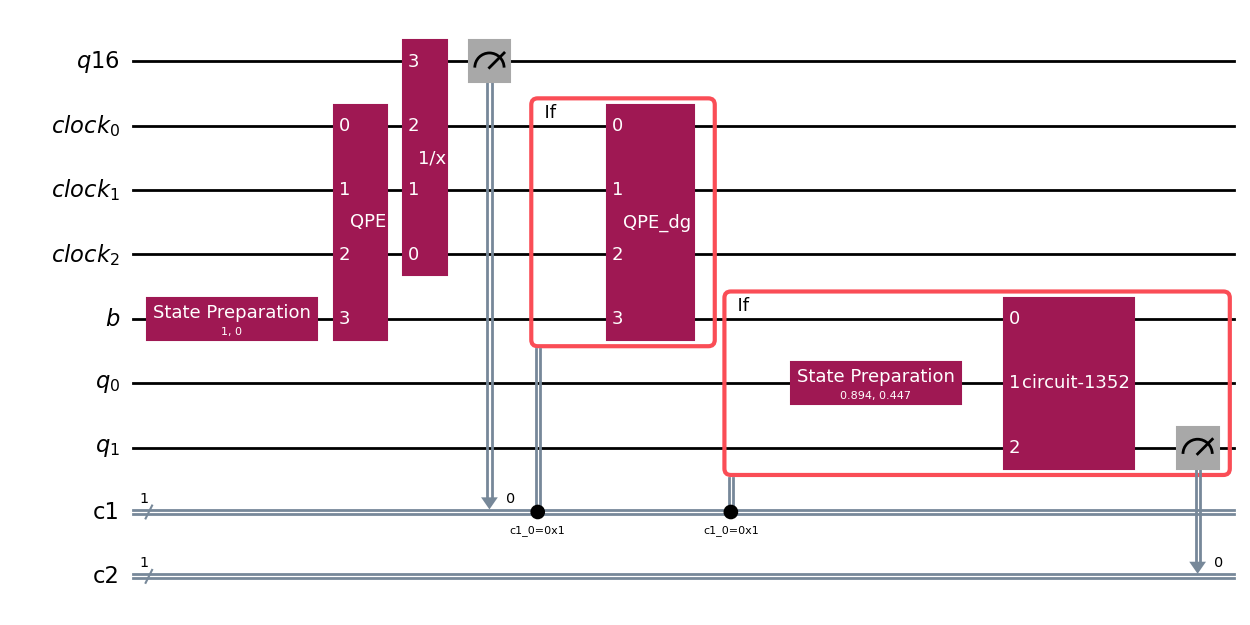

In [6]:
def create_swap_test_circuit(num_state_qubits):
    num_qubits = 2 * num_state_qubits + 1
    result = QuantumCircuit(num_qubits)
    result.h(-1)
    for i in range(num_state_qubits):
        result.cswap(-1, i, num_state_qubits + i)
    result.h(-1)
    return result

def get_ideal_x_statevector(A, b):
    x = np.linalg.solve(A, b)
    x_norm = np.linalg.norm(x)
    x_state = x/x_norm
    return Statevector(x_state)

π = np.pi
λ = 1/4
maxλ = 1
num_clock_qubits = 3
scale = abs((0.5-2**-num_clock_qubits)/maxλ)
A = np.array([[ 1/2 , λ-1/2],[λ-1/2,  1/2 ]])
b = np.array([[1.], [0.]])

hamiltonian_simulation = HamiltonianGate(A, -2 * π * scale)
state_preparation = StatePreparation(Statevector(b))
qpe = PhaseEstimation(num_clock_qubits, hamiltonian_simulation)
eigenvalue_inversion = ExactReciprocal(num_clock_qubits, 2*2**-num_clock_qubits, neg_vals=True)
flag = QuantumRegister(1)
clock_reg = QuantumRegister(num_clock_qubits, "clock")
b_reg = QuantumRegister(qpe.num_qubits - num_clock_qubits, "b")
c_reg = ClassicalRegister(1, "c1")
circuit = QuantumCircuit(flag, clock_reg, b_reg, c_reg)
circuit.append(state_preparation, b_reg)
circuit.append(qpe, clock_reg[:] + b_reg[:])
circuit.append(eigenvalue_inversion, clock_reg[::-1]+[flag[0]])
circuit.measure(0, 0)
with circuit.if_test((0,1)) as passed:
    circuit.append(qpe.inverse(), clock_reg[:] + b_reg[:])
num_b_qubits = int(np.log2(b.size))
st_circuit = create_swap_test_circuit(num_b_qubits)
q_reg = QuantumRegister(st_circuit.num_qubits - num_b_qubits, "q")
c2_reg = ClassicalRegister(1, "c2")
circuit.add_register(q_reg)
circuit.add_register(c2_reg)
ideal_x_statevector = get_ideal_x_statevector(A, b)
with circuit.if_test((0,1)) as passed:
    circuit.prepare_state(ideal_x_statevector, q_reg[:-1])
    circuit.append(st_circuit, range(-st_circuit.num_qubits, 0))
    circuit.measure(-1, c2_reg[0])

display(circuit.draw(output='mpl'))

# backend = AerSimulator()
# transpiled_circuit = transpile(circuit, backend)
# job = backend.run(transpiled_circuit)
# counts = job.result().get_counts()
# print(counts)
